In [ ]:
pip install -q -U datasets bitsandbytes peft git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from datasets import load_dataset
from PIL import Image
import torch
from transformers import BitsAndBytesConfig, Trainer, TrainingArguments, PaliGemmaProcessor, AutoProcessor, PaliGemmaForConditionalGeneration
from peft import get_peft_model, LoraConfig
import os

In [ ]:
!huggingface-cli login --token $HF_TOKEN --add-to-git-credential

Token is valid (permission: write).
The token `paligemma-adapter` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
device = "cuda"
model_id = "google/paligemma2-3b-pt-224"
dataset_path = "bernardomota/establishment-name-vqa"
model_output = "paligemma2-qlora-st-vqa-estnamevqa-224"

In [ ]:
def resize_and_process(batch):
    """
    Resize images in the batch if necessary and return the updated batch.

    Args:
        batch (dict): A dictionary containing images and potentially other data.

    Returns:
        dict: The updated batch with resized images.
    """
    max_size = 640
    images = batch['image']

    # Resize each image in the batch
    resized_images = []
    for img in images:
        width, height = img.size
        if max(width, height) > max_size:
            resize_ratio = max_size / max(width, height)
            new_width = int(width * resize_ratio)
            new_height = int(height * resize_ratio)
            img = img.resize((new_width, new_height), Image.LANCZOS)
        resized_images.append(img)

    batch['image'] = resized_images
    return batch

In [ ]:
ds_custom = load_dataset(dataset_path, trust_remote_code=True)
train_ds_custom = ds_custom["train"]
val_ds_custom = ds_custom["validation"]
train_ds_custom = train_ds_custom.map(resize_and_process, batched=True)
val_ds_custom = val_ds_custom.map(resize_and_process, batched=True)
print(train_ds_custom)
print(val_ds_custom)

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 41
})
Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 11
})


In [ ]:
# Function to process 'qas' and return expanded rows
def process_qas(examples):
    # Flatten the qas list and extract questions, answers, and images efficiently
    questions = [qa['question'] for qas_list in examples['qas'] for qa in qas_list]
    answers = [qa['answers'][-1] for qas_list in examples['qas'] for qa in qas_list]
    images = [image for image, qas_list in zip(examples['image'], examples['qas']) for _ in qas_list]

    return {'question': questions, 'image': images, 'answer': answers}

ds_stvqa = load_dataset('vikhyatk/st-vqa')['train']
ds_stvqa_sample = ds_stvqa.train_test_split(test_size=0.9)['train']
ds_stvqa_formatted = ds_stvqa_sample.map(process_qas, batched=True, remove_columns=['qas'])

# Split the dataset 90% for training, 10% for validation
ds_stvqa_formatted_split = ds_stvqa_formatted.train_test_split(test_size=0.1)

train_ds_stvqa = ds_stvqa_formatted_split['train']
val_ds_stvqa = ds_stvqa_formatted_split['test']
train_ds_stvqa = train_ds_stvqa.map(resize_and_process, batched=True)
val_ds_stvqa = val_ds_stvqa.map(resize_and_process, batched=True)
print(train_ds_stvqa)
print(val_ds_stvqa)

Map:   0%|          | 0/1892 [00:00<?, ? examples/s]

Map:   0%|          | 0/2353 [00:00<?, ? examples/s]

Map:   0%|          | 0/262 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 2353
})
Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 262
})


In [ ]:
import datasets

train_ds = datasets.concatenate_datasets([train_ds_custom, train_ds_stvqa])
val_ds = datasets.concatenate_datasets([val_ds_custom, val_ds_stvqa])
train_ds

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 2394
})

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7CFB37DA3A00>, 'question': 'What number is written on the bottom right side of the red bus?', 'answer': 'RT2634'}


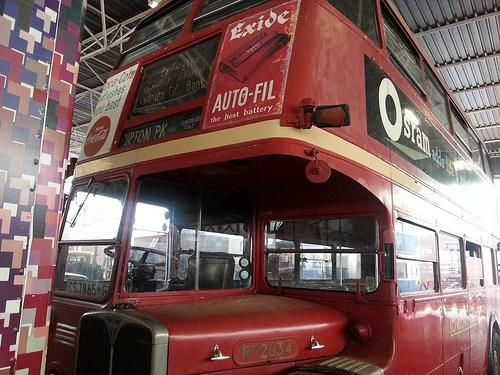

In [ ]:
idx = -1
print(train_ds[idx])
train_ds[idx]['image']

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x354 at 0x7CFB37DA2F20>, 'question': 'What is the visible name of the establishment in this image?', 'answer': 'THE SHACK RESTAURANT'}


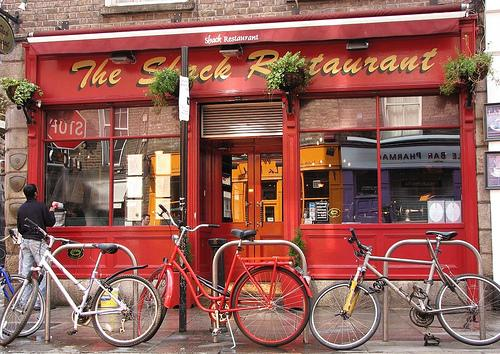

In [ ]:
idx = 0
print(val_ds[idx])
val_ds[idx]['image']

In [ ]:
processor = PaliGemmaProcessor.from_pretrained(model_id)

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_type=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0},
                                                          torch_dtype=torch.bfloat16)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

preprocessor_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

Unused kwargs: ['bnb_4bit_compute_type']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

trainable params: 11,876,352 || all params: 3,044,118,768 || trainable%: 0.3901


In [ ]:
args=TrainingArguments(
            num_train_epochs=1,
            remove_unused_columns=False,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            warmup_steps=2,
            learning_rate=2e-5,
            weight_decay=1e-6,
            adam_beta2=0.999,
            logging_steps=100,
            optim="paged_adamw_8bit", #adamw_hf
            save_strategy="steps",
            save_steps=1000,
            save_total_limit=1,
            bf16=True,
            output_dir=model_output,
            report_to=["tensorboard"],
            dataloader_pin_memory=False
        )

In [ ]:
DTYPE = model.dtype

def collate_fn(examples):
  texts = ["answer " + example["question"] for example in examples]
  labels= [example['answer'] for example in examples]
  images = [example["image"].convert("RGB") for example in examples]
  tokens = processor(text=texts, images=images, suffix=labels,
                    return_tensors="pt", padding="longest",
                    input_data_format="channels_last")

  tokens = tokens.to(DTYPE).to(device)
  return tokens

In [ ]:
trainer = Trainer(
        model=model,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=collate_fn,
        args=args
        )

In [ ]:
trainer.train()

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Step,Training Loss
100,26.100200


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Step,Training Loss
100,26.100200


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

TrainOutput(global_step=149, training_loss=22.28327603948196, metrics={'train_runtime': 4157.1485, 'train_samples_per_second': 0.576, 'train_steps_per_second': 0.036, 'total_flos': 9591881693042880.0, 'train_loss': 22.28327603948196, 'epoch': 0.9958228905597326})

In [ ]:
trainer.push_to_hub()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

events.out.tfevents.1735061221.7054b7576379.1134.0:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bernardomota/paligemma2-qlora-st-vqa-estnamevqa-224/commit/4f6624dfd0ee0716e831f7b1896a242acb20307c', commit_message='End of training', commit_description='', oid='4f6624dfd0ee0716e831f7b1896a242acb20307c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bernardomota/paligemma2-qlora-st-vqa-estnamevqa-224', endpoint='https://huggingface.co', repo_type='model', repo_id='bernardomota/paligemma2-qlora-st-vqa-estnamevqa-224'), pr_revision=None, pr_num=None)